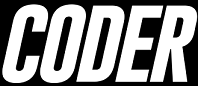

# Carga de datos
Utilizamos un conjunto de datos de alrededor de 37000 reseñas de videos de Amazon Instant Video y 1700000 reseñas de películas y programas de televisión, todas obtenidas del sitio web: http://jmcauley.ucsd.edu/data/amazon/. Tenga en cuenta que hay conjuntos de datos mucho más grandes disponibles en el mismo sitio. Podemos esperar resultados mejores y más consistentes en conjuntos de datos más grandes (como reseñas de libros). Tenga en cuenta que estos conjuntos de datos están comprimidos (gzip) y están en formato JSON, cada línea representa una revisión y cada línea es su propio objeto JSON.

Comenzamos cargando el conjunto de datos a continuación:

In [4]:
%%time
import gzip
import json
import string

import nltk # imports the natural language toolkit
import pandas as pd
import plotly

nltk.download('punkt')

import os

CPU times: total: 641 ms
Wall time: 662 ms


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jorge\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


```python
from google.colab import drive
import os
drive.mount('/content/gdrive')
# Establecer ruta de acceso en dr
import os
print(os.getcwd())
os.chdir("/content/gdrive/My Drive")
```

In [5]:
os.getcwd()
instant_video = pd.read_json("reviews_Amazon_Instant_Video_5.json.gz", lines=True, compression='gzip')

In [6]:
type(instant_video)
instant_video.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A11N155CW1UV02,B000H00VBQ,AdrianaM,"[0, 0]",I had big expectations because I love English ...,2,A little bit boring for me,1399075200,"05 3, 2014"
1,A3BC8O2KCL29V2,B000H00VBQ,Carol T,"[0, 0]",I highly recommend this series. It is a must f...,5,Excellent Grown Up TV,1346630400,"09 3, 2012"
2,A60D5HQFOTSOM,B000H00VBQ,"Daniel Cooper ""dancoopermedia""","[0, 1]",This one is a real snoozer. Don't believe anyt...,1,Way too boring for me,1381881600,"10 16, 2013"
3,A1RJPIGRSNX4PW,B000H00VBQ,"J. Kaplan ""JJ""","[0, 0]",Mysteries are interesting. The tension betwee...,4,Robson Green is mesmerizing,1383091200,"10 30, 2013"
4,A16XRPF40679KG,B000H00VBQ,Michael Dobey,"[1, 1]","This show always is excellent, as far as briti...",5,Robson green and great writing,1234310400,"02 11, 2009"


**Problema de negocio**. Su tarea principal es explorar los datos proporcionados y utilizar los resultados de su investigación para diseñar funciones relevantes que podrían facilitar el análisis posterior y la creación de modelos.

In [8]:
%%time
# podemos decirle a pandas que nuestro archivo esta en formato gzip y realizara el proceso de descompresion 
# para esto usamos el atributo `lines=True` para indicar que cada linea en el archivo tiene su propio JSON object
#instant_video = pd.read_json("reviews_Amazon_Instant_Video_5.json.gz", lines=True, compression='gzip')
# ----------
# El archivo Películas y TV es muy grande. Si tienes problemas para cargarlo, puedes cargar solo los primeros
# 100,000 reseñas usando 'chunksize' (elimine el comentario de la línea con 'chunksize' y comente la línea
# después de lo que carga el archivo completo en `movies_tv`). Todo el análisis puede ser
# hecho de la misma manera utilizando solo el subconjunto de revisiones, pero algunos de los resultados pueden ser diferentes de los ejemplos.
# ----------
movies_tv = next(pd.read_json("reviews_Amazon_Instant_Video_5.json.gz", lines=True, compression='gzip', chunksize=100000))
#movies_tv = pd.read_json("reviews_Movies_and_TV_5.json.gz", lines=True, compression='gzip')

CPU times: total: 797 ms
Wall time: 813 ms


Miremos algunos de los atributos

* **reviewerID:** A unique ID to identify the author of the review.
* **asin:** The ["Amazon Standard Identification Number"](https://www.amazon.com/gp/seller/asin-upc-isbn-info.html) which provides more information about the exact product and version.
* **reviewerName:** The username chosen by the reviewer.
* **helpful:** A record of how many users indicated that the review was helpful/not helpful.
* **reviewText:** The full text of the review.
* **overall:** The overall rating (1-5) left by the reviewer.
* **summary:** A short version of the review, used as the title.
* **unixReviewTime:** The date that the review was created, in [Unix Epoch](https://en.wikipedia.org/wiki/Unix_time) format.
* **reviewTime:** A human readable date giving the day, month, and year.

In [9]:
print(len(instant_video))
print(instant_video.head(5))

37126
       reviewerID        asin                    reviewerName helpful  \
0  A11N155CW1UV02  B000H00VBQ                        AdrianaM  [0, 0]   
1  A3BC8O2KCL29V2  B000H00VBQ                         Carol T  [0, 0]   
2   A60D5HQFOTSOM  B000H00VBQ  Daniel Cooper "dancoopermedia"  [0, 1]   
3  A1RJPIGRSNX4PW  B000H00VBQ                  J. Kaplan "JJ"  [0, 0]   
4  A16XRPF40679KG  B000H00VBQ                   Michael Dobey  [1, 1]   

                                          reviewText  overall  \
0  I had big expectations because I love English ...        2   
1  I highly recommend this series. It is a must f...        5   
2  This one is a real snoozer. Don't believe anyt...        1   
3  Mysteries are interesting.  The tension betwee...        4   
4  This show always is excellent, as far as briti...        5   

                          summary  unixReviewTime   reviewTime  
0      A little bit boring for me      1399075200   05 3, 2014  
1           Excellent Grown Up TV 

In [10]:
print(len(movies_tv))
print(movies_tv.head(5))

37126
       reviewerID        asin                    reviewerName helpful  \
0  A11N155CW1UV02  B000H00VBQ                        AdrianaM  [0, 0]   
1  A3BC8O2KCL29V2  B000H00VBQ                         Carol T  [0, 0]   
2   A60D5HQFOTSOM  B000H00VBQ  Daniel Cooper "dancoopermedia"  [0, 1]   
3  A1RJPIGRSNX4PW  B000H00VBQ                  J. Kaplan "JJ"  [0, 0]   
4  A16XRPF40679KG  B000H00VBQ                   Michael Dobey  [1, 1]   

                                          reviewText  overall  \
0  I had big expectations because I love English ...        2   
1  I highly recommend this series. It is a must f...        5   
2  This one is a real snoozer. Don't believe anyt...        1   
3  Mysteries are interesting.  The tension betwee...        4   
4  This show always is excellent, as far as briti...        5   

                          summary  unixReviewTime   reviewTime  
0      A little bit boring for me      1399075200   05 3, 2014  
1           Excellent Grown Up TV 

Notamos que `movies_tv` es extremadamente larga con casi 2 millones de reseñas, y varias columnas parecen poco interesantes o difíciles de trabajar (por ejemplo, `reviewerID`, `asin`, `reviewername`, `reviewtime`). Dejamos caer alguna información para hacer que algunos de nuestros análisis posteriores sean más eficientes. También agregamos una columna de fecha y hora con objetos de fecha y hora de Python para resumir más fácilmente los datos:

Comenzamos cargando el conjunto de datos a continuación:

In [11]:
%%time
movies_tv['datetime'] = pd.to_datetime(movies_tv['reviewTime'], format="%m %d, %Y")
instant_video['datetime'] = pd.to_datetime(instant_video['reviewTime'], format="%m %d, %Y")

CPU times: total: 453 ms
Wall time: 592 ms


In [12]:
movies_tv = movies_tv.drop(columns = ['reviewerID', 'asin', 'reviewerName', 'reviewTime'])
instant_video = instant_video.drop(columns = ['reviewerID', 'asin', 'reviewerName', 'reviewTime'])

movies_tv.head(5)

,helpful,reviewText,overall,summary,unixReviewTime,datetime
0,"[0, 0]",I had big expectations because I love English ...,2,A little bit boring for me,1399075200,2014-05-03
1,"[0, 0]",I highly recommend this series. It is a must f...,5,Excellent Grown Up TV,1346630400,2012-09-03
2,"[0, 1]",This one is a real snoozer. Don't believe anyt...,1,Way too boring for me,1381881600,2013-10-16
3,"[0, 0]",Mysteries are interesting. The tension betwee...,4,Robson Green is mesmerizing,1383091200,2013-10-30
4,"[1, 1]","This show always is excellent, as far as briti...",5,Robson green and great writing,1234310400,2009-02-11


In [13]:
movies_tv.datetime.value_counts().head(20)

datetime
2014-02-10    292
2014-01-28    259
2014-02-08    257
2014-02-09    226
2014-02-15    211
2014-03-25    210
2014-02-18    206
2014-02-07    199
2014-01-16    188
2014-02-06    187
2014-02-13    176
2013-04-19    173
2014-02-12    172
2014-04-02    171
2014-01-08    161
2014-03-06    157
2014-02-20    157
2014-02-11    156
2013-04-24    154
2013-11-03    152
Name: count, dtype: int64

<Axes: >

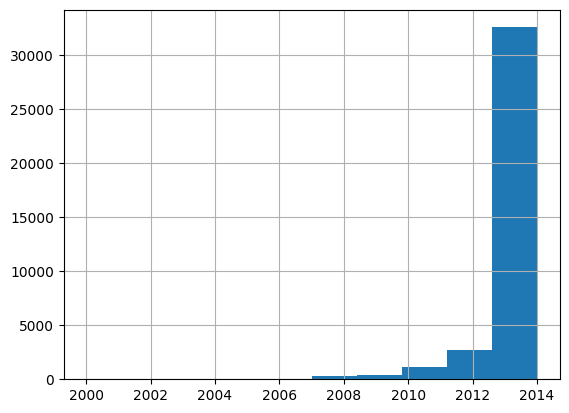

In [15]:
movies_tv.datetime.dt.year.hist()

# Histogramas de conteos

array([[<Axes: title={'center': 'overall'}>,
        <Axes: title={'center': 'unixReviewTime'}>],
       [<Axes: title={'center': 'datetime'}>, <Axes: >]], dtype=object)

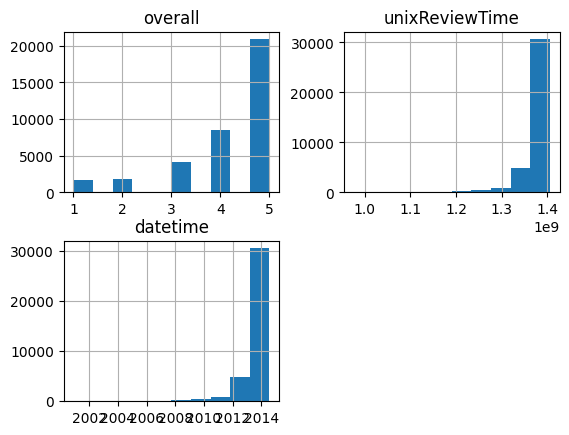

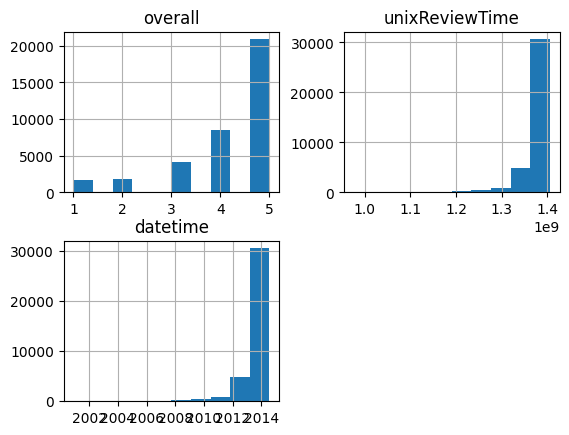

In [16]:
instant_video.hist()
movies_tv.hist()

Notamos eso:

1. La mayoría de las reseñas son buenas; de hecho, ¡más de la mitad son perfectas (5/5 estrellas) en ambos conjuntos de datos!
2. Casi todas las revisiones de videos instantáneos son extremadamente recientes. Será muy difícil detectar tendencias sin corregir esto. Las reseñas de TV Movie están sustancialmente más dispersas (aunque también incluyen un pico reciente).

In [17]:
instant_video['year'] = instant_video.datetime.dt.year
instant_video.groupby(['year']).agg({'overall': 'mean', 'year': 'count'})

,overall,year
year,,
2000,5.000000,1
2004,4.000000,1
2006,4.937500,16
2007,4.245763,118
2008,4.298701,231
2009,4.251381,362
2010,4.093085,376
2011,4.012414,725
2012,4.111845,2727


In [18]:
movies_tv['year'] = movies_tv.datetime.dt.year
movies_tv.groupby(['year']).agg({'overall': 'mean', 'year': 'count'})

,overall,year
year,,
2000,5.000000,1
2004,4.000000,1
2006,4.937500,16
2007,4.245763,118
2008,4.298701,231
2009,4.251381,362
2010,4.093085,376
2011,4.012414,725
2012,4.111845,2727


# Promedio de ratings en el tiempo

In [19]:
result = instant_video.groupby(instant_video.datetime.dt.year).agg({'overall': 'mean', 'overall': 'count'})
result

,overall
datetime,
2000,1
2004,1
2006,16
2007,118
2008,231
2009,362
2010,376
2011,725
2012,2727


In [21]:
result = movies_tv.groupby(movies_tv.datetime.dt.year).agg({'overall': 'mean', 'overall': 'count'})
result

,overall
datetime,
2000,1
2004,1
2006,16
2007,118
2008,231
2009,362
2010,376
2011,725
2012,2727


<Axes: xlabel='datetime'>

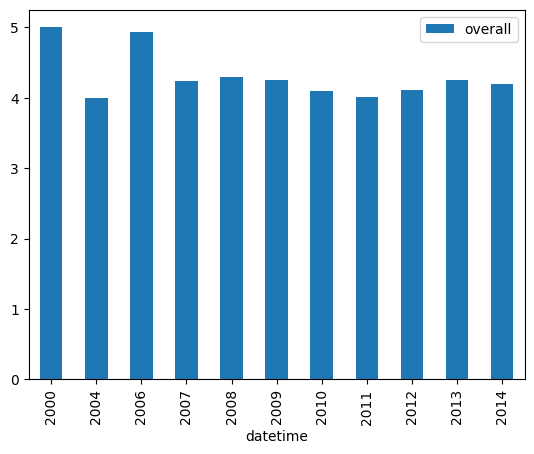

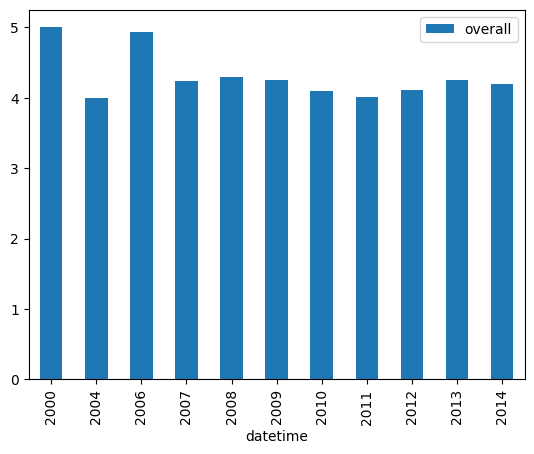

In [22]:
instant_video.groupby(instant_video.datetime.dt.year)['overall'].mean().to_frame().plot(kind="bar")
movies_tv.groupby(movies_tv.datetime.dt.year)['overall'].mean().to_frame().plot(kind="bar")

Notamos eso:

1. No hay tendencias notables de cambio de calificaciones con el tiempo.

2. Hay algunos años atípicos con calificaciones más altas, pero estos son años en los que la cantidad de revisiones es muy pequeña, lo que hace que el promedio sea menos confiable.

# Promedios longitudes de revisiones por año

<Axes: xlabel='datetime'>

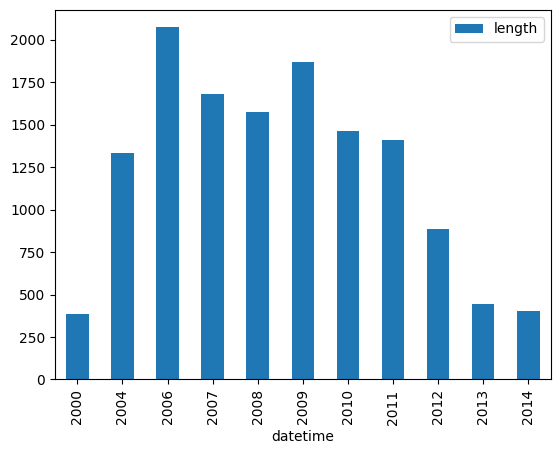

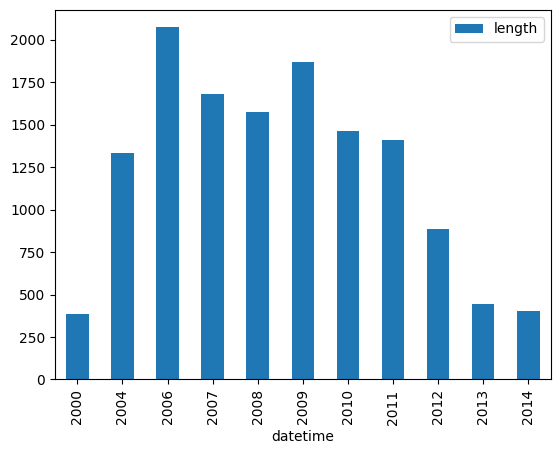

In [23]:
instant_video['length'] = instant_video['reviewText'].apply(len)
instant_video.groupby(instant_video.datetime.dt.year)['length'].mean().to_frame().plot(kind="bar")

movies_tv['length'] = movies_tv['reviewText'].apply(len)
movies_tv.groupby(movies_tv.datetime.dt.year)['length'].mean().to_frame().plot(kind="bar")

Observamos una aparente tendencia al alza en la duración de las reseñas durante la década de 1990 y principios de la de 2000, seguida de una tendencia a la baja. Debido a que ambos conjuntos de datos tienen revisiones más recientes, la tendencia a la baja en la duración de la revisión es más confiable.

# Encontrar palabras mas frecuentes

Encontremos las diez palabras sin stopwrods que aparecen con mayor frecuencia en: (i) todas las reseñas, (ii) reseñas positivas, (iii) reseñas negativas. ¿Te sorprenden los resultados? ¿Por qué o por qué no?

In [24]:
from sklearn.feature_extraction.text import CountVectorizer
from datetime import datetime

short_movies_tv = movies_tv.head(100000)

def get_top_n_words(corpus, n=1, k=1):
    t1 = datetime.now()
    vec = CountVectorizer(ngram_range=(k, k), stop_words="english")
    bag_of_words = vec.fit_transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

In [25]:
vec = CountVectorizer(ngram_range=(1, 1), stop_words="english")
bag_of_words = vec.fit_transform(short_movies_tv["reviewText"])

In [26]:
 bag_of_words.sum(axis=0) 

matrix([[145, 108,   1, ...,   1,   2,   1]])

season 16885
like 14748
series 12901
good 12663
just 11465
great 10594
34 10184
really 9097
love 8989
watch 8989
characters 8696
story 8008
movie 7625
episode 7578
time 7137
film 6745
watching 5927
people 5509
episodes 5376
don 5323
CPU times: total: 2.45 s
Wall time: 2.47 s


<Axes: title={'center': 'Top 20 words from all reviews'}, xlabel='words'>

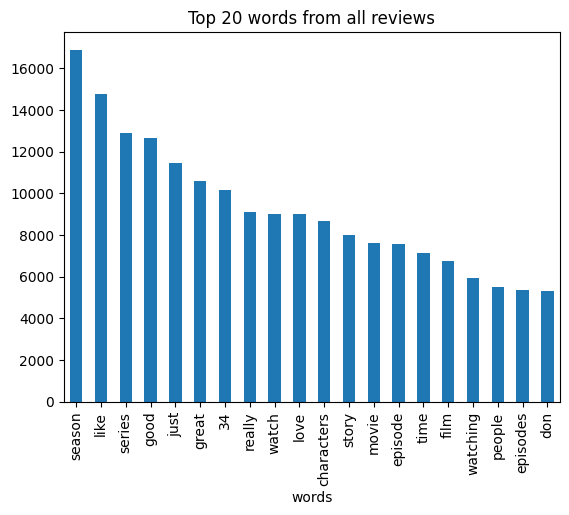

In [27]:
%%time
# Todos los reviews
common_words = get_top_n_words(short_movies_tv["reviewText"], 20, 1)
for word, freq in common_words:
    print(word, freq)
    
df = pd.DataFrame(common_words, columns=["words", "count"])
df.groupby("words").sum()["count"].sort_values(ascending=False).plot(
    kind="bar", title="Top 20 words from all reviews"
)

season 14255
series 10914
like 10206
good 9692
great 9375
love 8003
just 7342
34 7138
watch 6912
characters 6685
really 6511
episode 5936
story 5701
time 5046
watching 4566
episodes 4292
shows 4230
movie 4200
film 3912
new 3842
CPU times: total: 1.77 s
Wall time: 1.75 s


<Axes: title={'center': 'Top 20 words from good reviews'}, xlabel='words'>

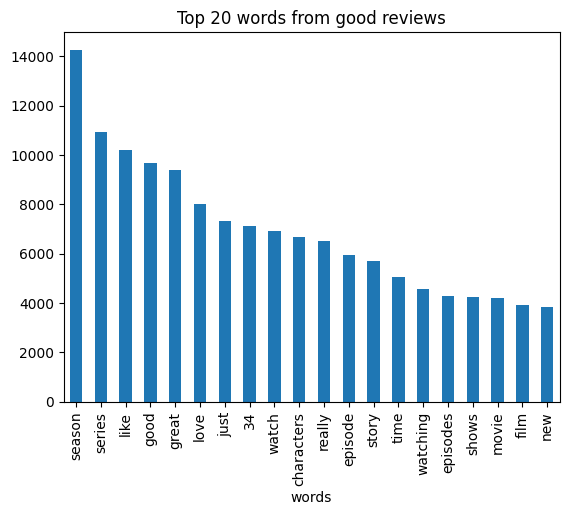

In [28]:
%%time
# reviews Positivos
good_indices = short_movies_tv["overall"] > 3.1
good_reviews = short_movies_tv[good_indices]
bad_indices = short_movies_tv["overall"] < 2.1
bad_reviews = short_movies_tv[bad_indices]

common_words = get_top_n_words(good_reviews["reviewText"], 20)
for word, freq in common_words:
    print(word, freq)

df = pd.DataFrame(common_words, columns=["words", 'count'])
df.groupby('words').sum()['count'].sort_values(ascending=False).plot(
    kind='bar', title='Top 20 words from good reviews'
)

just 2198
like 2123
movie 1784
34 1412
film 1206
really 1176
good 1148
don 1021
time 1002
people 958
story 952
watch 948
characters 909
bad 874
season 834
make 751
series 746
episode 727
way 674
watching 670
CPU times: total: 438 ms
Wall time: 388 ms


<Axes: title={'center': 'Top 20 words from bad reviews'}, xlabel='words'>

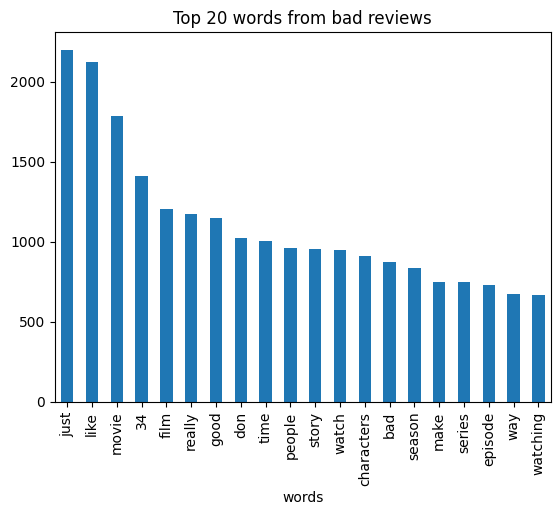

In [29]:
%%time
# reviews Negativos
common_words = get_top_n_words(bad_reviews['reviewText'], 20)
for word, freq in common_words:
    print(word, freq)
df = pd.DataFrame(common_words, columns=['words', 'count'])
df.groupby('words').sum()['count'].sort_values(ascending=False).plot(
    kind='bar', title='Top 20 words from bad reviews'
)

Tengan en cuenta que los resultados son casi idénticos en los tres grupos de reseñas: casi todas las palabras más importantes son palabras genéricas muy comunes sobre películas (es decir, "película" en sí). Como vimos en el caso anterior, esto no es tan sorprendente, dado que estamos tratando con datos en un contexto específico de una película, y las palabras vacías solo tendrán en cuenta las palabras genéricas que aparecen en muchos contextos en inglés, las stopwords más comunes serán el vocabulario básico relacionado con las películas, no necesariamente palabras más precisas que den más color a las reseñas en sí.

Encuentremos las palabras que sean indicativas de malas críticas. Es decir, palabras que aparecen a menudo en malas críticas y no en buenas críticas. ¿Qué son estas palabras y son sorprendentes?

CPU times: total: 1 s
Wall time: 1.02 s


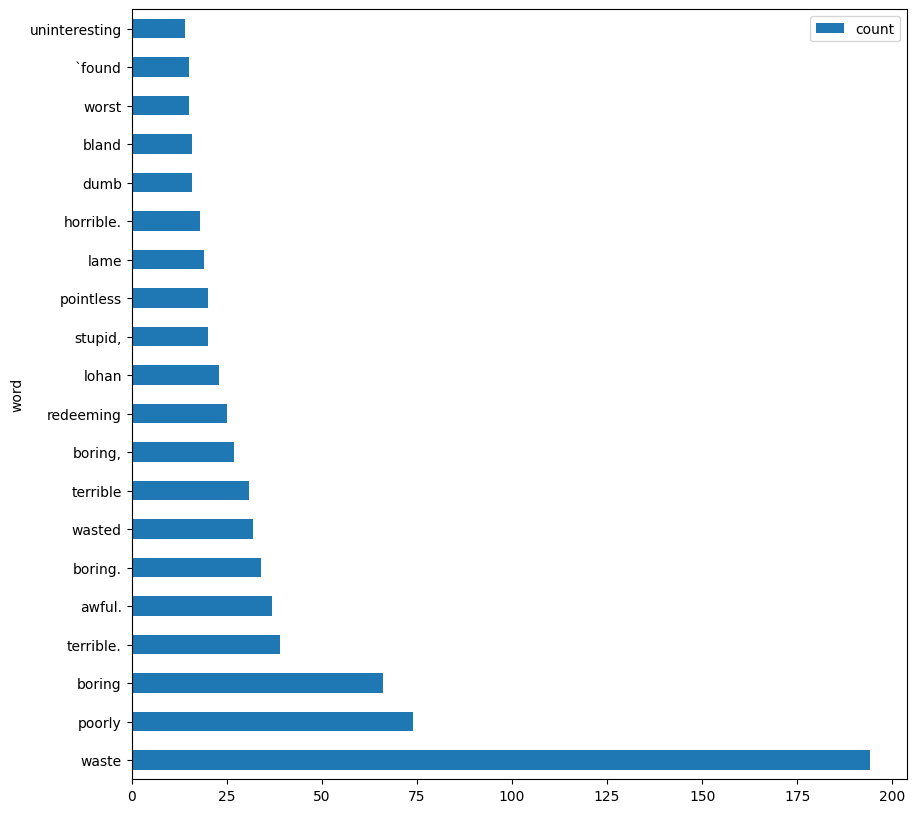

In [30]:
%%time
from collections import Counter

def get_indicative_words(text1, text2, n=20):
    c1 = Counter(text1.lower().split(" "))
    c2 = Counter(text2.lower().split(" "))
    ind_words_1 = (c1 - c2).most_common(n)
    ind_words_2 = (c2 - c1).most_common(n)    
    x, y = zip(*ind_words_2)
    
    df = pd.DataFrame({'word': x, 'count': y})
    df.plot.barh(
        x='word', y='count', figsize=(10,10)
    )

get_indicative_words(' '.join(good_reviews['reviewText']), ' '.join(bad_reviews['reviewText']))

In [31]:
text1 = ' '.join(good_reviews['reviewText'])
text2 = ' '.join(bad_reviews['reviewText'])


In [32]:
c1 = Counter(text1.lower().split(" "))
c2 = Counter(text2.lower().split(" "))
ind_words_1 = (c1 - c2).most_common(20)
ind_words_2 = (c2 - c1).most_common(20)

In [33]:
c1 - c2

Counter({'the': 111578,
         'and': 65248,
         'a': 51203,
         'to': 48099,
         'of': 46127,
         'is': 39508,
         '': 38570,
         'i': 37641,
         'this': 27550,
         'in': 25745,
         'it': 24589,
         'that': 20556,
         'for': 16400,
         'with': 16095,
         'as': 15452,
         'are': 13687,
         'but': 13524,
         'on': 13471,
         'you': 12334,
         'show': 11962,
         'was': 11961,
         'season': 10116,
         'have': 9978,
         'not': 8784,
         'they': 8632,
         'be': 8247,
         'all': 7810,
         'like': 7661,
         'great': 7637,
         'one': 7630,
         'his': 7561,
         'so': 7374,
         'has': 7095,
         'love': 7092,
         'good': 7009,
         'he': 6802,
         'more': 6797,
         'my': 6623,
         'series': 6507,
         'very': 6432,
         'from': 6350,
         'an': 6262,
         'who': 6040,
         'at': 5864,
         

In [34]:
ind_words_1

[('the', 111578),
 ('and', 65248),
 ('a', 51203),
 ('to', 48099),
 ('of', 46127),
 ('is', 39508),
 ('', 38570),
 ('i', 37641),
 ('this', 27550),
 ('in', 25745),
 ('it', 24589),
 ('that', 20556),
 ('for', 16400),
 ('with', 16095),
 ('as', 15452),
 ('are', 13687),
 ('but', 13524),
 ('on', 13471),
 ('you', 12334),
 ('show', 11962)]

Notamos que muchas de las palabras son obviamente indicativas de una mala película, como "horrible", "decepción", "horrible". "Canjeable" es una palabra interesante que no tiene una asociación negativa obvia, pero probablemente indica que incluso en las críticas negativas, los revisores tienden a hablar de "una característica de redimir algo" (o afirman que la película). También hay algo de ruido en los datos, como es normal en los datos de texto. "g" y "shao" no parecen palabras significativas.

Inspeccionemos manualmente las primeras 10 reseñas negativas que contengan la palabra "buena". ¿Que notaste? ¿Cómo sugiere esto que debemos proceder a continuación?

Una posible solución se da a continuación. Tenga en cuenta que el uso de códigos de escape Ansi para colorear es un "buen extra" y no se espera necesariamente de las soluciones de los estudiantes:

In [35]:
v_bad_indices = movies_tv['overall'] < 1.1
v_bad_reviews = movies_tv[v_bad_indices]

RED_START = "\033[91m"
END = "\033[0m"

good_word_bad_review = [rev for rev in v_bad_reviews['reviewText'] if 'good' in rev.lower()]

print(len(good_word_bad_review))
for rev in good_word_bad_review[:1000]:
    good_i = rev.lower().index("good")

    # adicionamos los codigos Ansi para hacer un highlight a los matches
    print(rev[good_i-50: good_i] + RED_START + rev[good_i:good_i+4] + END + rev[good_i+4:good_i +50])

326
good job with good production values, casting and 
neveryone..the story line is fine and the writing good for the set up.I love the parents and always 
ould be fun if she wasn't so hateful inside.  Not good.  Yuck.
too much nudity and sex in it. The story line was good but didn't enjoy the rest.
 extreme as that character is. If you wanna see a good portrayal of that disease watch Parenthood or
 somehow get better.  It doesn't.  The premise is good.  It could have been a good show.  But it is 
he dialog. all of it. and the girls. not hot, but good for stripper quality i guess.
de SYFY but what I got was just terrible. Nothing good about this piece of crap.
organ are just not funny at all.  Alec Bladwin is good and kind of funny, but it's almost like you f
tempt to be taken seriously, it could have been a good comic satire.
onwhacko conspiracy type plot and bad corporation,good citizen defending the "wetlands" and nature.C
y crash are being wasted that could be used for a good purpo

Vemos que "bueno" se usa de diferentes maneras en las críticas negativas. Por ejemplo:

1. A veces, el revisor señala algo que es realmente bueno, antes de decir que esto no compensa problemas más importantes.
2. A veces, el crítico dice que algo bueno no está presente, ya que "casi todo lo que he visto hasta ahora no se parece al buen cine de ninguna manera".
3. De vez en cuando, la palabra "bueno" se refiere a la moralidad.

Revise la lista de malas críticas que contienen la palabra "buena" que encontramos en la última pregunta. Para cada revisión, extraiga lo siguiente:

1. La primera palabra después de "good"
2. La primera palabra después de "good" que es un sustantivo o cardinal
3. La última palabra antes de "good" que es un sustantivo o cardinal

In [ ]:
# PArte i
import re

post_good = []
for sentence in good_word_bad_review:
    
    # extraer la palabra seguida de good. Hacemos un strip de caracteres 
    post = re.search("good.?\W*(\w+).*\s?", sentence, re.IGNORECASE)
    
    # si good es la ultima palabra en el review no habra palabra
    # despues de ella
    if post:
        post_good.append(post.groups()[0])
    
post_good = [i for i in post_good if i] 
print(post_good[0:10])

['the', 'but', 'for', 'plot', 'cinema', 'and', 'or', 'and', 'because', 'to']


In [ ]:
# Parte ii
nltk.download('averaged_perceptron_tagger')
good_pos = ['CD', 'FW', 'NN', 'NNS', 'NNP', 'NNPS']

def extract_interesting(sentence, good):
    words = nltk.word_tokenize(sentence)
    interesting = [k for k, v in nltk.pos_tag(words) if v in good]
    return(interesting)

# Usamos esto para definir una nueva funcion para la proxima palabra interesante
def next_word2(sentence):
    post = re.findall(r'good.*', sentence)
    if len(post) > 0:
        interesting = extract_interesting(post[0], good_pos)
        if (len(interesting) > 0):
            return(interesting[0])
        else:
            return('')
    else:
        return('')
    
# Finalmente, buscamos en nuestra lista 
post_good2 = []

for sentence in good_word_bad_review[:1000]:
    temp = next_word2(sentence)
    post_good2.append(temp)
    
post_good2 = [i for i in post_good2 if i] 
print(post_good2[0:10])


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


['story', 'scene', 'plot', 'cinema', 'history', 'benefit', 'scenes.To', 'filmmaker', 'extent', 'review']


In [ ]:
# parte III
# funcion para extraer palabras antes  de que parezca la palabra "good"

def prev_word(sentence):
    post = re.findall(r'.*?good', sentence)
    if (len(post) > 0):
        temp = extract_interesting(post[0],good_pos)
        if (len(temp) > 0):
            return(temp[len(temp)-1])
        else:
            return('')
    else:
        return('')
    
# Encontramos nuestra lista
pre_good = []
for sentence in good_word_bad_review[:1000]:
    temp = prev_word(sentence)
    pre_good.append(temp)
    
pre_good = [i for i in pre_good if i] 
print(pre_good[0:10])

['acting', 'transfer', 'story', 'everything', 'acting', 'nothing', 'flashbacks', 'symbol', '.They', 'film']


# n-grams

Hemos visto que las palabras individuales no siempre son muy informativas. Busque los bigramas y trigramas más informativos, tanto en reseñas positivas como negativas. Muestre los bigramas y trigramas más informativos y haga un breve análisis de los n-gramas que identificó.

In [ ]:
def get_top_n_words(corpus, n=1, k=1):
    vec = CountVectorizer(ngram_range=(k,k),stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

blu ray 6714
great movie 4300
ve seen 3895
special effects 3830
good movie 2669
love movie 2509
sci fi 2246
years ago 2191
movie great 2152
quot quot 1935
black white 1927
special features 1874
watch movie 1853
don know 1824
highly recommend 1812
year old 1799
seen movie 1774
new york 1720
great film 1683
real life 1471


<AxesSubplot:title={'center':'Top 20 bigrams from good reviews'}, xlabel='words'>

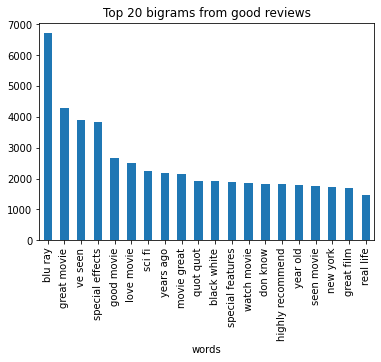

In [ ]:
# Bigramas con buenas revisiones
common_words = get_top_n_words(good_reviews['reviewText'], 20, 2)
for word, freq in common_words:
    print(word, freq)

df = pd.DataFrame(common_words, columns=['words', 'count'])
df.groupby('words').sum()['count'].sort_values(ascending=False).plot(
    kind='bar', title='Top 20 bigrams from good reviews'
)

tommy lee jones 779
nightmare elm street 640
does great job 467
world war ii 456
did great job 433
new york city 427
blu ray version 412
ve seen movie 383
highly recommend movie 350
based true story 344
blu ray release 316
does good job 310
did good job 283
country old men 273
special edition dvd 265
movie ve seen 262
dvd blu ray 251
haven seen movie 250
movies ve seen 247
does excellent job 216


<AxesSubplot:title={'center':'Top 20 trigrams from good reviews'}, xlabel='words'>

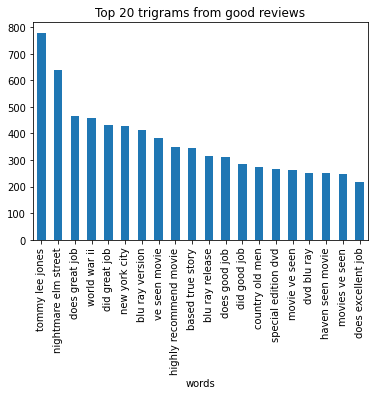

In [ ]:
# trigramas para buenas revisiones
common_words = get_top_n_words(good_reviews['reviewText'], 20, 3)
for word, freq in common_words:
    print(word, freq)

df = pd.DataFrame(common_words, columns=['words', 'count'])
df.groupby('words').sum()['count'].sort_values(ascending=False).plot(
    kind='bar', title='Top 20 trigrams from good reviews'
)

Algunos de los bigramas y trigramas están claramente relacionados con el tema, pero no necesariamente con buenas críticas. Por ejemplo, "blu ray", "lanzamiento de blu ray", "tommy lee jones", "historia real basada".

Otros están más obviamente relacionados específicamente con buenas críticas, como "hace un trabajo excelente", "muy recomendable", "gran película".

Las palabras importantes como "bueno" (así como las que aparecen en los otros n-gramas anteriores) tienden a ser adjetivos. Los adjetivos describen sustantivos. Más específicamente, un adjetivo casi siempre describe el sustantivo que le sigue y que está más cerca de él en una oración. A veces los adjetivos no van directamente después. Por ejemplo, "Esta fue una película buena e interesante" todavía tiene "buena" y "película" vinculadas.

Esto sugiere que podemos usar el etiquetado POS para extraer las ubicaciones de los adjetivos y sustantivos, luego iterar a través de todos los adjetivos y contar hacia adelante desde cada uno hasta llegar al siguiente sustantivo. Estas son nuestras palabras informativas.

Escribamos una(s) función(es) que transforme una oración en una nueva lista de texto emparejando iterativamente cada adjetivo en la oración con el siguiente sustantivo que le sigue en la oración. Por ejemplo, el texto "Esa fue una película larga y buena" debería devolver ["buena película", "película larga"].

In [ ]:
#Hacemos una función que toma el primer adjetivo y su sustantivo asociado, luego devuelve (i) el par y (ii) una oración más corta.
def grab_first_pair(sentence):
    words = nltk.word_tokenize(sentence)
    adjectives = [k for k, v in nltk.pos_tag(words) if v == 'JJ']
    if(len(adjectives) > 0):
        shorter = re.findall(adjectives[0] +'.*',sentence)[0]        
        words2 = nltk.word_tokenize(shorter)
        nouns = [k for k,v in nltk.pos_tag(words) if v == 'NN']
        if(len(nouns) > 0):
            shorter = shorter.split(' ', 1)[1]
            return(adjectives[0], nouns[0], shorter)
    return('', '', '')

# Creamos una funcion que use la anterior para iterar en las oraciones
def grab_all_pairs(sentence):
    pairs = []
    noun = ''
    adj =''
    while(len(sentence) > 0):
        adj, noun, sentence = grab_first_pair(sentence)
        if(adj != ''):
            pairs.append(adj + ' ' + noun)
    return(pairs)

#Creamos una funcion que itere por muchas oraciones luego de tokenizar
def make_pair_list(corpus):
    sentences = nltk.sent_tokenize(BigRev)
    pairs = []
    for sentence in sentences:
        pairs.extend(grab_all_pairs(sentence))

In [ ]:
sentence = "The big black dog scared the red cat."
print(grab_first_pair(sentence))
print(grab_all_pairs(sentence))

('big', 'dog', 'black dog scared the red cat.')
['big dog', 'black dog', 'red dog', 'red cat']
